## Assignment 1
Kusal Bista
1881044

#### Importing Libraries

In [2]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

import re
import string
import nltk

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk import ngrams
from collections import Counter

import spacy
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Embedding, Bidirectional, LSTM
from sklearn.metrics import classification_report, confusion_matrix, r2_score, accuracy_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_classification
from sklearn.utils import resample

nlp = spacy.load('en_core_web_sm')


In [3]:
# !pip install seaborn
# !pip install nltk
# !pip install spacy
# !python -m spacy download "en_core_web_sm

### 1. Reading datasets

#### 1.1 Loading Dataset

In [116]:
hotel_reviews = pd.read_json('random_30000_hotel_review.json', encoding='utf-8-sig')

In [117]:
hotel_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   ratings            30000 non-null  object        
 1   title              30000 non-null  object        
 2   text               30000 non-null  object        
 3   author             30000 non-null  object        
 4   date_stayed        28806 non-null  object        
 5   offering_id        30000 non-null  int64         
 6   num_helpful_votes  30000 non-null  int64         
 7   date               30000 non-null  datetime64[ns]
 8   id                 30000 non-null  int64         
 9   via_mobile         30000 non-null  bool          
dtypes: bool(1), datetime64[ns](1), int64(3), object(5)
memory usage: 2.1+ MB


In [118]:
hotel_reviews.head()

,ratings,title,text,author,date_stayed,offering_id,num_helpful_votes,date,id,via_mobile
0,"{'service': 1.0, 'cleanliness': 2.0, 'overall'...",“Horrible experience”,First of all we got there and they didn't have...,"{'username': 'Kh3RD', 'num_reviews': 1, 'id': ...",September 2012,80138,0,2012-09-19,140716137,False
1,"{'cleanliness': 1.0, 'sleep_quality': 1.0, 'ov...",“Stay Away”,Found Racist graffiti in the room. Request to ...,"{'username': 'TheUglyPhotographer', 'num_citie...",June 2011,240151,1,2011-06-27,114807323,False
2,"{'service': 4.0, 'cleanliness': 5.0, 'overall'...",“Great location and service”,Close to Union Square - hotel is a bit of a ma...,"{'username': 'Moonstonemoclips', 'num_cities':...",October 2010,80793,0,2010-10-25,84805430,False
3,"{'service': 3.0, 'cleanliness': 2.0, 'overall'...",“I will never go back here again!”,I had a bad vibe about this place from the mom...,"{'username': 'JoanellenJ', 'num_cities': 10, '...",June 2012,111418,1,2012-06-28,132971117,False
4,{'overall': 1.0},“Ripped off our VISA card after departure”,"After we received our ""final"" bill and left th...","{'username': 'Lynnworks', 'num_cities': 3, 'nu...",January 2012,671150,3,2012-02-04,124104157,False


In [7]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\a1881044\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\a1881044\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

#### 1.2 Concatenating Text and Title

In [119]:
hotel_reviews['text'] = hotel_reviews['title'].astype(str) + ' ' + hotel_reviews['text'].astype(str)

In [120]:
hotel_reviews.head()

,ratings,title,text,author,date_stayed,offering_id,num_helpful_votes,date,id,via_mobile
0,"{'service': 1.0, 'cleanliness': 2.0, 'overall'...",“Horrible experience”,“Horrible experience” First of all we got ther...,"{'username': 'Kh3RD', 'num_reviews': 1, 'id': ...",September 2012,80138,0,2012-09-19,140716137,False
1,"{'cleanliness': 1.0, 'sleep_quality': 1.0, 'ov...",“Stay Away”,“Stay Away” Found Racist graffiti in the room....,"{'username': 'TheUglyPhotographer', 'num_citie...",June 2011,240151,1,2011-06-27,114807323,False
2,"{'service': 4.0, 'cleanliness': 5.0, 'overall'...",“Great location and service”,“Great location and service” Close to Union Sq...,"{'username': 'Moonstonemoclips', 'num_cities':...",October 2010,80793,0,2010-10-25,84805430,False
3,"{'service': 3.0, 'cleanliness': 2.0, 'overall'...",“I will never go back here again!”,“I will never go back here again!” I had a bad...,"{'username': 'JoanellenJ', 'num_cities': 10, '...",June 2012,111418,1,2012-06-28,132971117,False
4,{'overall': 1.0},“Ripped off our VISA card after departure”,“Ripped off our VISA card after departure” Aft...,"{'username': 'Lynnworks', 'num_cities': 3, 'nu...",January 2012,671150,3,2012-02-04,124104157,False


#### 1.3 Moving all non-alphanumeric characters and tokenising the text.

In [121]:
def clean_text(text):
    text = re.sub('[^a-z A-Z 0-9-]+', '', text)
    # Remove non-ASCII characters
    text = ''.join([char for char in text if ord(char) < 128])
    # Tokenize the text
    tokens = word_tokenize(text)
    return " ".join(tokens)

hotel_reviews["clean_text"] = hotel_reviews["text"].apply(clean_text)

#### 1.3 Opening JSON inside of the rating column 

In [122]:
df =hotel_reviews.copy()
json_cols = ['ratings']

"Function for decoding JSON"
def clean_json(x):
    if isinstance(x, str):
        return json.loads(x)
    else:
        return x

for x in json_cols:
    df[x] = df[x].apply(clean_json)

normalized_cols = pd.json_normalize(df['ratings'])
df = df.join(normalized_cols)
df = df.drop(json_cols, axis=1)

In [123]:
df.head()

,title,text,author,date_stayed,offering_id,num_helpful_votes,date,id,via_mobile,clean_text,service,cleanliness,overall,value,location,sleep_quality,rooms,check_in_front_desk,business_service_(e_g_internet_access)
0,“Horrible experience”,“Horrible experience” First of all we got ther...,"{'username': 'Kh3RD', 'num_reviews': 1, 'id': ...",September 2012,80138,0,2012-09-19,140716137,False,Horrible experience First of all we got there ...,1.0,2.0,1.0,1.0,3.0,2.0,1.0,NaN,NaN
1,“Stay Away”,“Stay Away” Found Racist graffiti in the room....,"{'username': 'TheUglyPhotographer', 'num_citie...",June 2011,240151,1,2011-06-27,114807323,False,Stay Away Found Racist graffiti in the room Re...,1.0,1.0,1.0,2.0,NaN,1.0,NaN,NaN,NaN
2,“Great location and service”,“Great location and service” Close to Union Sq...,"{'username': 'Moonstonemoclips', 'num_cities':...",October 2010,80793,0,2010-10-25,84805430,False,Great location and service Close to Union Squa...,4.0,5.0,4.0,3.0,5.0,4.0,4.0,NaN,NaN
3,“I will never go back here again!”,“I will never go back here again!” I had a bad...,"{'username': 'JoanellenJ', 'num_cities': 10, '...",June 2012,111418,1,2012-06-28,132971117,False,I will never go back here again I had a bad vi...,3.0,2.0,2.0,1.0,4.0,1.0,1.0,NaN,NaN
4,“Ripped off our VISA card after departure”,“Ripped off our VISA card after departure” Aft...,"{'username': 'Lynnworks', 'num_cities': 3, 'nu...",January 2012,671150,3,2012-02-04,124104157,False,Ripped off our VISA card after departure After...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN


#### 1.4  Droping unwanted columns 

In [124]:
df_cleaned = df.copy()

In [125]:
df_cleaned = df_cleaned.drop(['date', 'sleep_quality', 'rooms', 'check_in_front_desk', 'title', 'text', 'num_helpful_votes', 'author', 'id', 'via_mobile', 'date_stayed', 'offering_id', 'service', 'cleanliness', 'business_service_(e_g_internet_access)','value', 'location'], axis=1)

#### 1.5 Thresholding sentiment from overall

In [126]:
sentiment = []
for i in range(len(df_cleaned['overall'])):
    if (df_cleaned['overall'].iloc[i].astype(float)<3.00):
        sentiment.append(0)
    else:
        sentiment.append(1)

In [127]:
df_cleaned['sentiment']=sentiment
df_cleaned['sentiment'].value_counts()

sentiment
1    26026
0     3974
Name: count, dtype: int64

In [128]:
df_cleaned = df_cleaned.drop(['overall'], axis=1)

#### 1.6 Final dataframe check

In [129]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   clean_text  30000 non-null  object
 1   sentiment   30000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 468.9+ KB


In [130]:
df_cleaned.head()

,clean_text,sentiment
0,Horrible experience First of all we got there ...,0
1,Stay Away Found Racist graffiti in the room Re...,0
2,Great location and service Close to Union Squa...,1
3,I will never go back here again I had a bad vi...,0
4,Ripped off our VISA card after departure After...,0


#### 1.7 Spliting data into training (first 10000 lines), development (next 10000 lines) and test (remaining 10000 lines).

In [20]:
# I have upsampled and have done slip down below
# X_train, X_remaining, y_train, y_remaining = train_test_split(df_cleaned["clean_text"], df_cleaned["sentiment"], train_size=10000, random_state=42)
# X_dev, X_test, y_dev, y_test = train_test_split(X_remaining, y_remaining, test_size=0.5, random_state=42)

### 2. Exploratory Data Analysis (EDA)

In [131]:
df_cleaned.describe()

,sentiment
count,30000.000000
mean,0.867533
std,0.339003
min,0.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,1.000000


####2.1 Sentiment Distribution

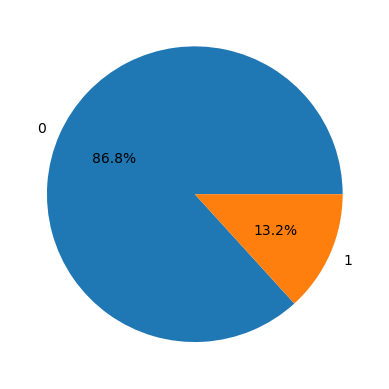

In [132]:
plt.pie(df_cleaned['sentiment'].value_counts(), labels=df_cleaned['sentiment'].unique().tolist(), autopct='%1.1f%%')
plt.show()

**More than one fourth data is positve.**

#### 2.2 Distribution of overall

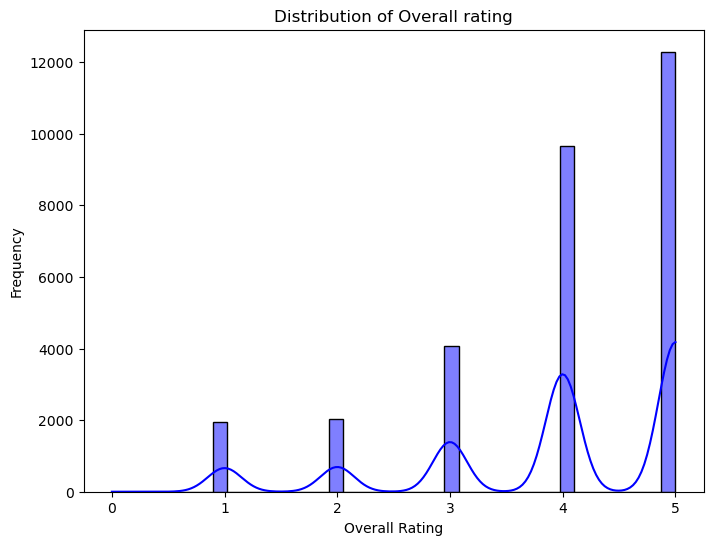

In [133]:
plt.figure(figsize=(8, 6))
sns.histplot(df['overall'].dropna(), kde=True, color='blue')
plt.title(f'Distribution of Overall rating')
plt.xlabel('Overall Rating')
plt.ylabel('Frequency')
plt.show()

In [134]:
# Function to get word frequencies for a given sentiment
def get_word_frequencies(sentiment):
  sentiment_text = ' '.join(df_cleaned[df_cleaned['sentiment'] == sentiment]['clean_text'])
  tokens = word_tokenize(sentiment_text)
  fdist = FreqDist(tokens)
  return fdist

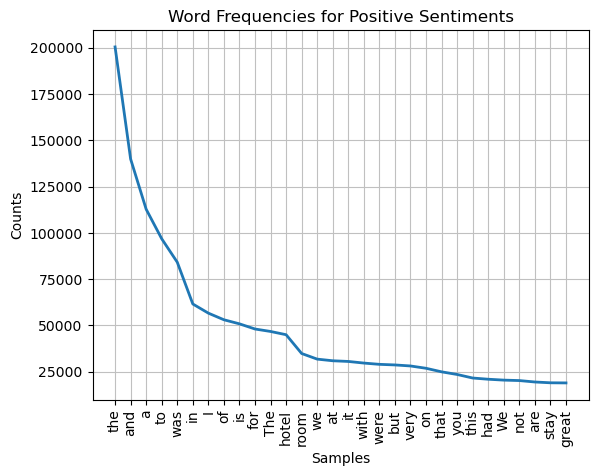

<Axes: title={'center': 'Word Frequencies for Positive Sentiments'}, xlabel='Samples', ylabel='Counts'>

In [135]:
positive_frequencies = get_word_frequencies(1)
plt.title('Word Frequencies for Positive Sentiments')
positive_frequencies.plot(30, cumulative=False)

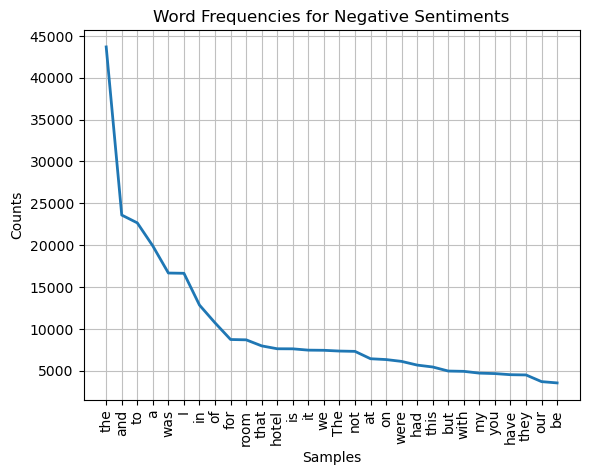

<Axes: title={'center': 'Word Frequencies for Negative Sentiments'}, xlabel='Samples', ylabel='Counts'>

In [26]:
 # Plot word frequencies for negative sentiment
negative_frequencies = get_word_frequencies(0)
# # plt.figure(figsize=(12, 6))
plt.title('Word Frequencies for Negative Sentiments')
negative_frequencies.plot(30, cumulative=False)
# # plt.show()

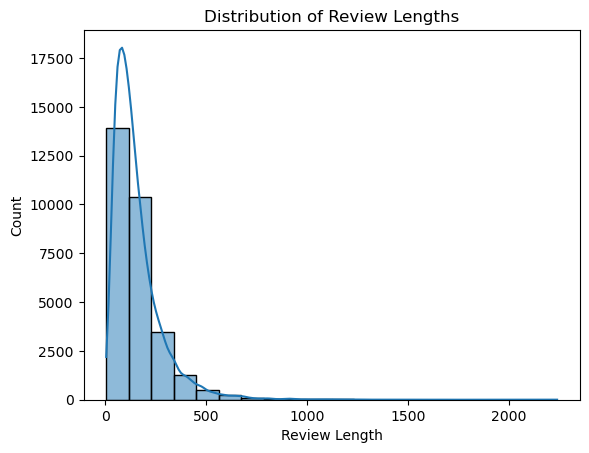

In [136]:
# Analyze the distribution of rating lengths
df_cleaned['text_length'] = df_cleaned['clean_text'].apply(lambda x: len(x.split()))
sns.histplot(df_cleaned['text_length'], bins=20, kde=True)
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length')
plt.show()

Distribution of 3-grams:
Ripped off our: 1
off our VISA: 1
our VISA card: 1
VISA card after: 1
card after departure: 1
after departure After: 1
departure After we: 1
After we received: 1
we received our: 1
received our final: 1
our final bill: 1
final bill and: 1
bill and left: 1
and left the: 1
left the Empire: 1
the Empire they: 1
Empire they assessed: 1
they assessed another: 1
assessed another 60: 1
another 60 charge: 1
60 charge on: 1
charge on our: 1
on our credit: 1
our credit card: 2
credit card Called: 1
card Called accounting: 1
Called accounting and: 1
accounting and sent: 1
and sent email: 1
sent email to: 1
email to ask: 1
to ask for: 1
ask for justification: 1
for justification no: 1
justification no response: 1
no response Have: 1
response Have asked: 1
Have asked our: 1
asked our credit: 1
credit card company: 1
card company to: 1
company to withhold: 1
to withhold payment: 1


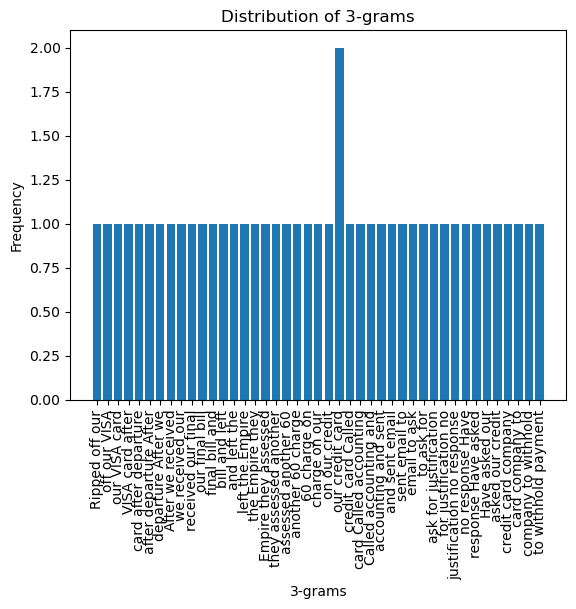

In [137]:

# Tokenize the text into words
tokens = nltk.word_tokenize(df_cleaned['clean_text'][4])

# Function to generate n-grams
def generate_ngrams(text, n):
    n_grams = ngrams(text, n)
    return [' '.join(gram) for gram in n_grams]

# Specify the value of n for n-grams
n_value = 3

# Generate n-grams
ngrams_list = generate_ngrams(tokens, n_value)

# Count the occurrences of each n-gram
ngrams_count = Counter(ngrams_list)

# Display the distribution
print(f"Distribution of {n_value}-grams:")
for ngram, count in ngrams_count.items():
    print(f"{ngram}: {count}")

# Plot the distribution
labels, values = zip(*ngrams_count.items())
indexes = range(len(labels))

plt.bar(indexes, values)
plt.xlabel(f'{n_value}-grams')
plt.ylabel('Frequency')
plt.xticks(indexes, labels, rotation='vertical')
plt.title(f'Distribution of {n_value}-grams')
plt.show()

### 3. Preprocessing

In [138]:
df_positive = df_cleaned[df_cleaned.sentiment == 1]
df_negitive = df_cleaned[df_cleaned.sentiment == 0]

df_upsampled = resample(df_negitive,
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_positive),    # to match majority class
                                 random_state=42) # reproducible results

# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_positive, df_upsampled])

In [139]:
df_upsampled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52052 entries, 2 to 14179
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   clean_text   52052 non-null  object
 1   sentiment    52052 non-null  int64 
 2   text_length  52052 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.6+ MB


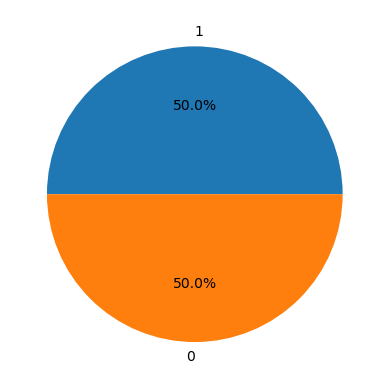

In [140]:
plt.pie(df_upsampled['sentiment'].value_counts(), labels=df_upsampled['sentiment'].unique().tolist(), autopct='%1.1f%%')
plt.show()

**Dataset is upsampled to normalize the dataset**

In [141]:
# Spliting the data into training and remaining (which will be further split into development and testing)
X_train, X_remaining, y_train, y_remaining = train_test_split(df_upsampled["clean_text"], df_upsampled["sentiment"], train_size=1/3, random_state=42)

# Further split the remaining data into development and testing
X_dev, X_test, y_dev, y_test = train_test_split(X_remaining, y_remaining, test_size=0.5, random_state=42)

### 4. Selecting supervised method for sentiment classification

In [142]:
# Spliting the development dataset into training and testing sets
X_train_dev, X_test_dev, y_train_dev, y_test_dev = train_test_split(X_dev, y_dev, test_size=0.5, random_state=42)

In [143]:
# Vectorizing the text using TF-IDF
vectorizer = TfidfVectorizer(min_df=3,  max_features=None,
             analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english', lowercase=False)
print(vectorizer)

TfidfVectorizer(lowercase=False, min_df=3, ngram_range=(1, 3), smooth_idf=1,
                stop_words='english', sublinear_tf=1, token_pattern='\\w{1,}',
                use_idf=1)


In [144]:
X_train_dev_vector = vectorizer.fit_transform(X_train_dev)
X_test_dev_vector = vectorizer.transform(X_test_dev)

In [145]:
# Models to run
models = [RandomForestClassifier(),SVC(), KNeighborsClassifier(),MultinomialNB()]

# List to store accuracy and F1 scores
accuracy = []
f1_scores = []

for model in models:
    cross_val_accuracy = cross_val_score(model, X_train_dev_vector, y_train_dev, scoring='accuracy', cv=StratifiedKFold(10)).mean()
    cross_val_f1 = cross_val_score(model, X_train_dev_vector, y_train_dev, scoring='f1_macro', cv=StratifiedKFold(10)).mean()
    accuracy.append(cross_val_accuracy)
    f1_scores.append(cross_val_f1)

# Model names
models_name = ['RandomForestClassifier', 'SVC', 'KNeighborsClassifier', 'MultinomialNB']
# Creating DataFrame to store model names, accuracy, and F1 scores
results = pd.DataFrame({'Model': models_name, 'Accuracy': accuracy, 'F1 Score': f1_scores})
print(results)

                    Model  Accuracy  F1 Score
0  RandomForestClassifier  0.912046  0.916866
1                     SVC  0.935793  0.935779
2    KNeighborsClassifier  0.821903  0.820378
3           MultinomialNB  0.894985  0.894437


**While performing sentiment analysis, where our end goal is to determine either the textual data is positive or negative, we select accuary and F1 score as a metries for evaluating the model performance. Accuracy provides the complete performance, where it measures the proportion of correctly predicted sentiments out of all the instances in the dataset.**
 
**The dataset was upsampled to address the class imbalance which affects the quality of the model's prediction hence we choose 'F1 Score' for another evaluation metrics. 'F1 score' considers the harmonic mean of precision and recall. It is relevent for evaluating the balance between correctly identifying positive and negative sentiments and capturing all instances of positive and negative sentiments.**

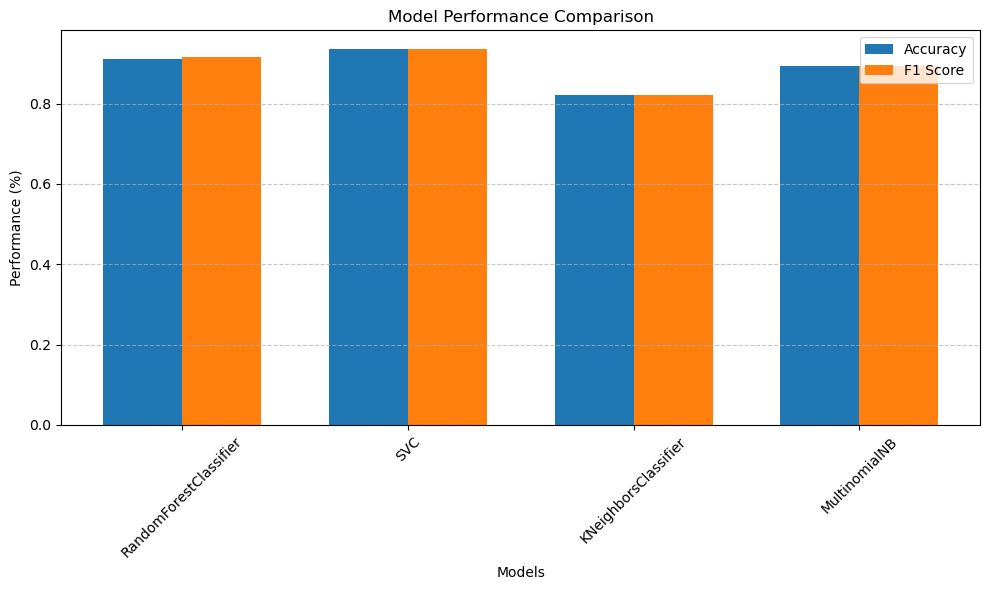

In [154]:
# Plotting
plt.figure(figsize=(10, 6))
bar_width = 0.35
index = range(len(results))

plt.bar(index, results['Accuracy'], bar_width, label='Accuracy')
plt.bar([i + bar_width for i in index], results['F1 Score'], bar_width, label='F1 Score')

# Adding labels and title
plt.xlabel('Models')
plt.ylabel('Performance (%)')
plt.title('Model Performance Comparison')
plt.xticks([i + bar_width / 2 for i in index], results['Model'], rotation=45)
plt.legend()

# Show plot
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**We can clearly see, Support Vector Classifier (SVC) out performs other with highest accuracy and F1 score. Secondly, random Forest has slightly less accuracy than SVC. SVC out performs other with highest accuracy and F1 score. Secondly, random Forest has slightly less accuracy than SVC.**

#### Linear Regression

In [146]:
from sklearn.metrics import mean_squared_error

# Training the linear regression model
model = LinearRegression()
model.fit(X_train_dev_vector, y_train_dev)

# Predicting on the test set
y_pred = model.predict(X_test_dev_vector)

# Calculating mean squared error
mse = mean_squared_error(y_test_dev, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.060246813847988835


#### Multilayer perceptron

In [147]:
# plot accuracy and loss
def plot_history(history):
    accuracy = history.history['accuracy']
    val_accuracy= history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(accuracy) + 1)
    plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')

    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()


# plot model architecture
def plot_model(model):
    model.summary()
    return tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
    layer_range=None,
    )

In [148]:
X_train_dev_reshaped = X_train_dev.values.reshape(X_train_dev.shape[0], 1, -1)  # Reshape for LSTM input
X_test_dev_reshaped = X_test_dev.values.reshape(X_test_dev.shape[0], 1, -1)  # Reshape for LSTM input

In [149]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.regularizers import l2
from tensorflow.keras import layers

tokenizer = Tokenizer(num_words=25000, oov_token='<OOV>')

tokenizer.fit_on_texts(X_train_dev)
# print(tokenizer.word_index)
total_word = len(tokenizer.word_index)
print('Total distinct words: {}'.format(total_word))

train_seq = tokenizer.texts_to_sequences(X_train_dev)
train_padded = pad_sequences(train_seq)

test_seq = tokenizer.texts_to_sequences(X_test_dev)
test_padded = pad_sequences(test_seq)

# One hot encoding the label
lb = LabelBinarizer()
train_labels = lb.fit_transform(y_train_dev)
test_labels = lb.transform(y_test_dev)

Total distinct words: 32400


In [150]:
model = tf.keras.models.Sequential([tf.keras.layers.Embedding(total_word, 8),
                                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
                                    tf.keras.layers.Dropout(0.5),
                                    tf.keras.layers.Dense(8, kernel_regularizer=l2(0.001),
                                                          bias_regularizer=l2(0.001), activation='relu'),
                                    tf.keras.layers.Dropout(0.5),
                                    tf.keras.layers.Dense(1, activation='softmax')])

model.summary() #[3] 

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 8)           259200    
                                                                 
 bidirectional_3 (Bidirecti  (None, 32)                3200      
 onal)                                                           
                                                                 
 dropout_6 (Dropout)         (None, 32)                0         
                                                                 
 dense_6 (Dense)             (None, 8)                 264       
                                                                 
 dropout_7 (Dropout)         (None, 8)                 0         
                                                                 
 dense_7 (Dense)             (None, 1)                 9         
                                                      

In [151]:
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_padded, train_labels, epochs=25, validation_data=(test_padded, test_labels))

Epoch 1/25
272/272 [==============================] - 107s 387ms/step - loss: 0.0114 - accuracy: 0.4986 - val_loss: 0.0115 - val_accuracy: 0.4912
Epoch 2/25
272/272 [==============================] - 105s 385ms/step - loss: 0.0119 - accuracy: 0.4986 - val_loss: 0.0123 - val_accuracy: 0.4912
Epoch 3/25
272/272 [==============================] - 105s 386ms/step - loss: 0.0128 - accuracy: 0.4986 - val_loss: 0.0133 - val_accuracy: 0.4912
Epoch 4/25
272/272 [==============================] - 105s 385ms/step - loss: 0.0139 - accuracy: 0.4986 - val_loss: 0.0145 - val_accuracy: 0.4912
Epoch 5/25
272/272 [==============================] - 105s 387ms/step - loss: 0.0153 - accuracy: 0.4986 - val_loss: 0.0161 - val_accuracy: 0.4912
Epoch 6/25
272/272 [==============================] - 105s 385ms/step - loss: 0.0169 - accuracy: 0.4986 - val_loss: 0.0178 - val_accuracy: 0.4912
Epoch 7/25
272/272 [==============================] - 105s 386ms/step - loss: 0.0188 - accuracy: 0.4986 - val_loss: 0.0198 -

In [44]:
df_upsampled.head()

,clean_text,sentiment,text_length
2,Great location and service Close to Union Squa...,1,56
5,A great location Steps to Grand Central a very...,1,22
6,Its all about the Location This Hotel is locat...,1,377
7,Five Star Service I stayed with my teenage boy...,1,126
8,Good airport hotel in Seattle Very good airpor...,1,180


#### Grid Search CV on SVM 

In [152]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid']
}

svm_model = SVC()
# Performing Grid Search with cross-validation
grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=10, scoring='accuracy', verbose=1, n_jobs=-1)

# Fitting the data to the grid search
grid_search.fit(X_train_dev_vector, y_train_dev)

print("Best parameters found: ", grid_search.best_params_)
print("Best accuracy found: ", grid_search.best_score_)

Fitting 10 folds for each of 64 candidates, totalling 640 fits
Best parameters found:  {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
Best accuracy found:  0.9372923742552051


#### SVM after Stop word removal

In [45]:
# Removing stopword
def clean_text(text):
    # text = text.lower()
    # Remove stopwords and punctuation
    tokens = word_tokenize(text)
    stop_words = stopwords.words("english") + list(string.punctuation)
    tokens = [token for token in tokens if token not in stop_words]
    # text1 = " ".join(tokens)
    # doc = nlp(text1)
    # tokens = [token.lemma_ for token in doc]
    return " ".join(tokens)

df_upsampled["clean_text_1"] = df_upsampled["clean_text"].apply(clean_text)

In [46]:
df_upsampled = df_upsampled.drop(['clean_text','text_length'],axis=1)

In [47]:
df_stop_word_removed = df_upsampled.copy()

In [48]:
df_stop_word_removed.head()

,sentiment,clean_text_1
2,1,Great location service Close Union Square hote...
5,1,A great location Steps Grand Central well situ...
6,1,Its Location This Hotel located right heart Sa...
7,1,Five Star Service I stayed teenage boys resort...
8,1,Good airport hotel Seattle Very good airporrt ...


In [49]:
df_stop_word_removed["clean_text_1"][5]

'A great location Steps Grand Central well situated hotel midtown within walking distance shops theatres restaurants'

In [50]:
# Spliting the data into training and remaining (which will be further split into development and testing)
X_train, X_remaining, y_train, y_remaining = train_test_split(df_stop_word_removed["clean_text_1"], df_stop_word_removed["sentiment"], train_size=1/3, random_state=42)

# Further split the remaining data into development and testing
X_dev, X_test, y_dev, y_test = train_test_split(X_remaining, y_remaining, test_size=0.5, random_state=42)

# Spliting the development dataset into training and testing sets
X_train_dev, X_test_dev, y_train_dev, y_test_dev = train_test_split(X_dev, y_dev, test_size=0.5, random_state=42)

In [51]:
# training an SVC classifier
svc_classifier = SVC(C=10, gamma=1, kernel='rbf')

svc_classifier.fit(X_train_dev_vector, y_train_dev)

# Making predictions on the vectorized test set
y_pred_svc = svc_classifier.predict(X_test_dev_vector)

# Calculate accuracy
accuracy = accuracy_score(y_test_dev, y_pred_svc)
print("Accuracy:", accuracy)


Accuracy: 0.940179806362379


In [52]:
print("F1 score:", f1_score(y_test_dev, y_pred_svc))
print(classification_report(y_test_dev, y_pred_svc))

F1 score: 0.9389483590165864
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      4414
           1       0.94      0.94      0.94      4262

    accuracy                           0.94      8676
   macro avg       0.94      0.94      0.94      8676
weighted avg       0.94      0.94      0.94      8676



#### SVM after Lemmatisation

In [53]:
# Removing stopword
def clean_text(text):
    # text = text.lower()
    # Remove stopwords and punctuation
    tokens = word_tokenize(text)
    stop_words = stopwords.words("english") + list(string.punctuation)
    tokens = [token for token in tokens if token not in stop_words]
    text1 = " ".join(tokens)
    doc = nlp(text1)
    tokens = [token.lemma_ for token in doc]
    return " ".join(tokens)

df_upsampled["clean_text_2"] = df_upsampled["clean_text_1"].apply(clean_text)

In [54]:
df_upsampled = df_upsampled.drop(['clean_text_1'],axis=1)

In [55]:
df_lemmanted = df_upsampled.copy()

In [56]:
df_lemmanted.head()

,sentiment,clean_text_2
2,1,great location service Close Union Square hote...
5,1,a great location Steps Grand Central well situ...
6,1,its location this Hotel locate right heart San...
7,1,five Star Service I stay teenage boy resort on...
8,1,good airport hotel Seattle very good airporrt ...


In [57]:
df_lemmanted["clean_text_2"][5]

'a great location Steps Grand Central well situate hotel midtown within walk distance shop theatre restaurant'

In [58]:
# Spliting the data into training and remaining (which will be further split into development and testing)
X_train, X_remaining, y_train, y_remaining = train_test_split(df_lemmanted["clean_text_2"], df_lemmanted["sentiment"], train_size=1/3, random_state=42)

# Further split the remaining data into development and testing
X_dev, X_test, y_dev, y_test = train_test_split(X_remaining, y_remaining, test_size=0.5, random_state=42)

# Spliting the development dataset into training and testing sets
X_train_dev, X_test_dev, y_train_dev, y_test_dev = train_test_split(X_dev, y_dev, test_size=0.5, random_state=42)

In [59]:
# training an SVC classifier
svc_classifier = SVC(C=10, gamma=1, kernel='rbf')

svc_classifier.fit(X_train_dev_vector, y_train_dev)

# Making predictions on the vectorized test set
y_pred_svc = svc_classifier.predict(X_test_dev_vector)

# Calculate accuracy
accuracy = accuracy_score(y_test_dev, y_pred_svc)
print("Accuracy:", accuracy)


Accuracy: 0.940179806362379


In [60]:
print("F1 score:", f1_score(y_test_dev, y_pred_svc))
print(classification_report(y_test_dev, y_pred_svc))

F1 score: 0.9389483590165864
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      4414
           1       0.94      0.94      0.94      4262

    accuracy                           0.94      8676
   macro avg       0.94      0.94      0.94      8676
weighted avg       0.94      0.94      0.94      8676



#### SVM after lowering text

In [61]:
def clean_text(text):
    text = text.lower()
    # Remove stopwords and punctuation
    tokens = word_tokenize(text)
    stop_words = stopwords.words("english") + list(string.punctuation)
    tokens = [token for token in tokens if token not in stop_words]
    text1 = " ".join(tokens)
    doc = nlp(text1)
    tokens = [token.lemma_ for token in doc]
    return " ".join(tokens)

df_upsampled["clean_text_3"] = df_upsampled["clean_text_2"].apply(clean_text)

In [62]:
df_upsampled = df_upsampled.drop(['clean_text_2'],axis=1)

In [63]:
df_preprocessing = df_upsampled.copy()

In [64]:
df_preprocessing.head()

,sentiment,clean_text_3
2,1,great location service close union square hote...
5,1,great location step grand central well situate...
6,1,location hotel locate right heart san francisc...
7,1,five star service stay teenage boy resort one ...
8,1,good airport hotel seattle good airporrt hotel...


In [65]:
df_preprocessing["clean_text_3"][5]

'great location step grand central well situate hotel midtown within walk distance shop theatre restaurant'

In [66]:
# Spliting the data into training and remaining (which will be further split into development and testing)
X_train, X_remaining, y_train, y_remaining = train_test_split(df_lemmanted["clean_text_3"], df_lemmanted["sentiment"], train_size=1/3, random_state=42)

# Further split the remaining data into development and testing
X_dev, X_test, y_dev, y_test = train_test_split(X_remaining, y_remaining, test_size=0.5, random_state=42)

# Spliting the development dataset into training and testing sets
X_train_dev, X_test_dev, y_train_dev, y_test_dev = train_test_split(X_dev, y_dev, test_size=0.5, random_state=42)

In [67]:
# training an SVC classifier
svc_classifier = SVC(C=10, gamma=1, kernel='rbf')

svc_classifier.fit(X_train_dev_vector, y_train_dev)

# Making predictions on the vectorized test set
y_pred_svc = svc_classifier.predict(X_test_dev_vector)

# Calculate accuracy
accuracy = accuracy_score(y_test_dev, y_pred_svc)
print("Accuracy:", accuracy)


Accuracy: 0.940179806362379


In [68]:
print("F1 score:", f1_score(y_test_dev, y_pred_svc))
print(classification_report(y_test_dev, y_pred_svc))

F1 score: 0.9389483590165864
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      4414
           1       0.94      0.94      0.94      4262

    accuracy                           0.94      8676
   macro avg       0.94      0.94      0.94      8676
weighted avg       0.94      0.94      0.94      8676



**For my dataset I had no significant effect on the performance of text processing. I tried stop-word removal, lemmatization and lowercasing. This suggesst that the characteristics of the given dataset is relatively clean and homogeneous**

### 5. Sentiment classification using VADER lexicon and method

In [69]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\a1881044\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [70]:
def predict_and_test(model, X_test_bag_of_words):
    predicted_y = model.predict(X_test_bag_of_words)
    print((y_test==predicted_y)/len(y_test))

In [71]:
# Initialize SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

In [72]:
for text in X_test_dev[:4]:
    score = analyser.polarity_scores(text)
    if score['pos'] > score['neg'] :
        print(text+": "+"VADER positive\n")
    else:
        print(text+": "+"VADER negative\n")

La Quinta spanish gross we rent two room suite two teenage daughter husband if completely exhausted desperate room would return front desk get refund when enter room first thing notice toilet run non - stop we call front desk credit maintenance man within 5 minute within 15 minute problem fix we leave go dinner time get back room around 10 pm check 830 pm I go refrigerator away dinner leave this I notice dirty around frig I get look find floor bathroom dirty when I inspect bed I find sheet one bed rather large stain look like rust I hope we use bed also bed bottom sheet fit sheet flat one would stay someone would sleep the fold sofa dip middle like sway - back horse they enough coffee supply one person I could go also enough towel three people maintenence man use several wipe mess leave wet towel floor I call front desk towel tell come front desk get when husband complain morning return key management give we 50 179 rate I know long I could believe poor quality room: VADER negative

lo

In [73]:
df_preprocessing.head()

,sentiment,clean_text_3
2,1,great location service close union square hote...
5,1,great location step grand central well situate...
6,1,location hotel locate right heart san francisc...
7,1,five star service stay teenage boy resort one ...
8,1,good airport hotel seattle good airporrt hotel...


In [ ]:
# df_preprocessing = df_preprocessing.drop(['label','neg','neu','pos','compound','predicted_label'],axis=1)

In [74]:
df_preprocessing['sentiments'] = df_preprocessing['clean_text_3'].apply(lambda sentiments: analyser.polarity_scores(sentiments))

In [75]:
df_preprocessing = pd.concat([df_preprocessing.drop(['sentiments'], axis=1), df_preprocessing['sentiments'].apply(pd.Series)], axis=1)

In [76]:
df_preprocessing.head()

,sentiment,clean_text_3,neg,neu,pos,compound
2,1,great location service close union square hote...,0.000,0.746,0.254,0.8360
5,1,great location step grand central well situate...,0.000,0.566,0.434,0.8481
6,1,location hotel locate right heart san francisc...,0.048,0.690,0.262,0.9916
7,1,five star service stay teenage boy resort one ...,0.000,0.631,0.369,0.9825
8,1,good airport hotel seattle good airporrt hotel...,0.059,0.707,0.234,0.9571


In [77]:
df_preprocessing['predicted_label'] = df_preprocessing['compound'].apply(lambda score: 'pos' if score >= 0 else 'neg')

In [78]:
df_preprocessing['label'] = df_preprocessing['sentiment'].replace({1: 'pos', 0: 'neg'})

In [79]:
df_preprocessing.head()

,sentiment,clean_text_3,neg,neu,pos,compound,predicted_label,label
2,1,great location service close union square hote...,0.000,0.746,0.254,0.8360,pos,pos
5,1,great location step grand central well situate...,0.000,0.566,0.434,0.8481,pos,pos
6,1,location hotel locate right heart san francisc...,0.048,0.690,0.262,0.9916,pos,pos
7,1,five star service stay teenage boy resort one ...,0.000,0.631,0.369,0.9825,pos,pos
8,1,good airport hotel seattle good airporrt hotel...,0.059,0.707,0.234,0.9571,pos,pos


In [80]:
#ACCURACY
100*accuracy_score(df_preprocessing['label'], df_preprocessing['predicted_label'])

66.93498808883425

In [81]:
print(classification_report(df_preprocessing['label'], df_preprocessing['predicted_label']))

              precision    recall  f1-score   support

         neg       0.97      0.35      0.52     26026
         pos       0.60      0.99      0.75     26026

    accuracy                           0.67     52052
   macro avg       0.78      0.67      0.63     52052
weighted avg       0.78      0.67      0.63     52052



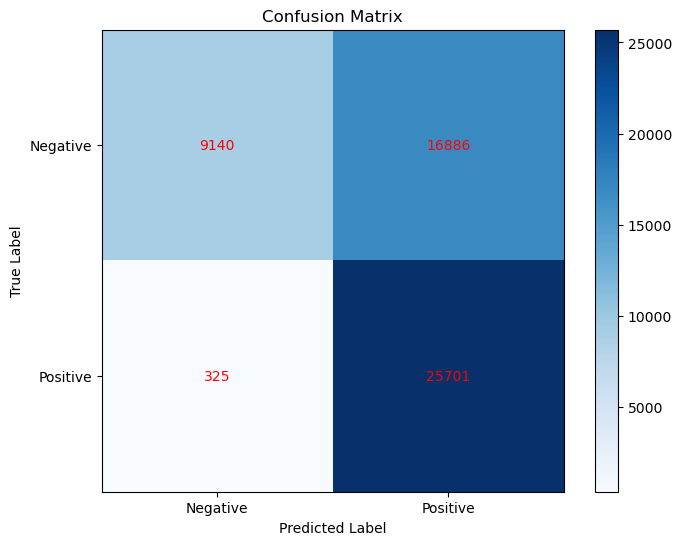

In [82]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(df_preprocessing['label'], df_preprocessing['predicted_label'])

# Plot the confusion matrix with annotations
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, cmap=plt.cm.Blues)

# Add annotations
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, str(conf_matrix[i, j]), ha='center', va='center', color='red')

plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks([0, 1], ['Negative', 'Positive'])  
plt.yticks([0, 1], ['Negative', 'Positive'])  
plt.show()

**The initial model without VADER performed well across all the metrics, with high precision, recall, and F1-score, resulting in an accuracy of 0.94.
Using VADER model significantly dropped the performance, specially in terms of recall for negitive sentiment, i.e. 0.35. Using VADER we achieved high precision both positive and negative sentiment however, the overall accuarcy is lower compared to the initial model with out VADER[2]**

### 6. Combining VADER with the best classifier

In [83]:
sid = SentimentIntensityAnalyzer()
rating_df = df_preprocessing.copy()

In [84]:
rating_df.head()

,sentiment,clean_text_3,neg,neu,pos,compound,predicted_label,label
2,1,great location service close union square hote...,0.000,0.746,0.254,0.8360,pos,pos
5,1,great location step grand central well situate...,0.000,0.566,0.434,0.8481,pos,pos
6,1,location hotel locate right heart san francisc...,0.048,0.690,0.262,0.9916,pos,pos
7,1,five star service stay teenage boy resort one ...,0.000,0.631,0.369,0.9825,pos,pos
8,1,good airport hotel seattle good airporrt hotel...,0.059,0.707,0.234,0.9571,pos,pos


In [85]:

# add number of characters column
rating_df["nb_chars"] = rating_df["clean_text_3"].apply(lambda x: len(x))

# add number of words column
rating_df["nb_words"] = rating_df["clean_text_3"].apply(lambda x: len(x.split(" ")))

In [ ]:
# !pip install gensim

In [86]:
# create doc2vec vector columns
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(rating_df["clean_text_3"].apply(lambda x: x.split(" ")))]

# train a Doc2Vec model with our text data
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

# transform each document into a vector data
doc2vec_df = rating_df["clean_text_3"].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
doc2vec_df.columns = ["doc2vec_vector_" + str(x) for x in doc2vec_df.columns]
reviews_df = pd.concat([rating_df, doc2vec_df], axis=1)

In [87]:
# add tf-idfs columns
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df = 10)
tfidf_result = tfidf.fit_transform(rating_df["clean_text_3"]).toarray()
tfidf_df = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names())
tfidf_df.columns = ["word_" + str(x) for x in tfidf_df.columns]
tfidf_df.index = reviews_df.index
reviews_df = pd.concat([reviews_df, tfidf_df], axis=1)

In [88]:
reviews_df[reviews_df["nb_words"] >= 5].sort_values("pos", ascending = False)[["clean_text_3", "pos"]].head(10)

,clean_text_3,pos
3690,exciting love hotel friendliness staff helpful...,0.892
21714,great value great value money location good,0.888
15489,fantastic clean great location great value wis...,0.887
6280,great staff nice hotel staff treat like specia...,0.874
29429,great stay would recommend family friend great...,0.855
13663,excellent room exceptionally clean comfortable...,0.844
12628,love back sure satisfied pleased servicedianne...,0.833
28943,fantastic stay clean clean clean great price n...,0.826
29315,great excellent location clean friendly staff ...,0.826
17085,nice warm people nice warm people,0.825


In [89]:
# lowest negative sentiment reviews (with more than 5 words)
reviews_df[reviews_df["nb_words"] >= 5].sort_values("neg", ascending = False)[["clean_text_3", "neg"]].head(10)

,clean_text_3,neg
28695,poor service stay poor service dissappointing,0.608
28695,poor service stay poor service dissappointing,0.608
28695,poor service stay poor service dissappointing,0.608
28695,poor service stay poor service dissappointing,0.608
17266,noisy dump radisson lax tired hotel noisy lous...,0.579
17266,noisy dump radisson lax tired hotel noisy lous...,0.579
17266,noisy dump radisson lax tired hotel noisy lous...,0.579
17266,noisy dump radisson lax tired hotel noisy lous...,0.579
17266,noisy dump radisson lax tired hotel noisy lous...,0.579
17266,noisy dump radisson lax tired hotel noisy lous...,0.579


In [90]:
reviews_df.head()

,sentiment,clean_text_3,neg,neu,pos,compound,predicted_label,label,nb_chars,nb_words,...,word_zen,word_zenith,word_zero,word_zesty,word_zig,word_zip,word_zippo,word_zombie,word_zone,word_zoo
2,1,great location service close union square hote...,0.000,0.746,0.254,0.8360,pos,pos,202,34,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1,great location step grand central well situate...,0.000,0.566,0.434,0.8481,pos,pos,105,15,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1,location hotel locate right heart san francisc...,0.048,0.690,0.262,0.9916,pos,pos,1104,181,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1,five star service stay teenage boy resort one ...,0.000,0.631,0.369,0.9825,pos,pos,385,62,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,1,good airport hotel seattle good airporrt hotel...,0.059,0.707,0.234,0.9571,pos,pos,518,83,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [91]:
reviews_df['predicted_label'] = reviews_df['predicted_label'].replace({'pos':1, 'neg': 0})

In [92]:
# feature selection
label = "sentiment"
ignore_cols = [label, "clean_text_3", "label"]
features = [c for c in reviews_df.columns if c not in ignore_cols]

In [93]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52052 entries, 2 to 14179
Columns: 12589 entries, sentiment to word_zoo
dtypes: float32(5), float64(12578), int64(4), object(2)
memory usage: 4.9+ GB


In [94]:
X_train, X_remaining, y_train, y_remaining = train_test_split(reviews_df[features], reviews_df[label], train_size=1/3, random_state=42)
X_dev, X_test, y_dev, y_test = train_test_split(X_remaining, y_remaining, test_size=0.5, random_state=42)

In [95]:
X_train_dev, X_test_dev, y_train_dev, y_test_dev = train_test_split(X_dev, y_dev, test_size=0.5, random_state=42)

In [96]:
X_train_dev

,neg,neu,pos,compound,predicted_label,nb_chars,nb_words,doc2vec_vector_0,doc2vec_vector_1,doc2vec_vector_2,...,word_zen,word_zenith,word_zero,word_zesty,word_zig,word_zip,word_zippo,word_zombie,word_zone,word_zoo
9797,0.103,0.701,0.197,0.9430,1,752,121,0.129078,0.356881,0.227680,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15219,0.195,0.627,0.178,-0.3164,0,1268,191,1.168869,-0.481284,0.911543,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5928,0.031,0.515,0.454,0.9805,1,252,42,-0.093535,0.401283,0.108901,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14103,0.000,0.540,0.460,0.9834,1,265,43,-0.182447,0.632580,0.836142,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25380,0.067,0.778,0.155,0.9313,1,684,98,0.510183,0.687961,1.059001,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23487,0.197,0.556,0.248,0.5574,1,330,50,0.025483,0.731949,0.305771,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29160,0.161,0.417,0.422,0.6124,1,71,12,-0.050668,0.211277,0.395006,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7800,0.024,0.654,0.322,0.9750,1,431,68,-0.143738,0.522224,0.978003,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15229,0.188,0.727,0.084,-0.9518,0,896,147,1.093039,0.447478,1.309254,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [97]:
# training an SVC classifier
svc_classifier = SVC(C=10, gamma=1, kernel='rbf')
svc_classifier.fit(X_train_dev, y_train_dev)

y_pred_svc = svc_classifier.predict(X_test_dev)

In [98]:
# Calculate accuracy
accuracy = accuracy_score(y_test_dev, y_pred_svc)
print("Accuracy:", accuracy)

Accuracy: 0.8280313508529276


In [99]:
print("F1 score:", f1_score(y_test_dev, y_pred_svc))
print(classification_report(y_test_dev, y_pred_svc))

F1 score: 0.8509490509490508
              precision    recall  f1-score   support

           0       1.00      0.66      0.80      4414
           1       0.74      1.00      0.85      4262

    accuracy                           0.83      8676
   macro avg       0.87      0.83      0.82      8676
weighted avg       0.87      0.83      0.82      8676



### 7. Trainig and testing the final method

In [100]:
# training an SVC classifier
svc_classifier = SVC(C=10, gamma=1, kernel='rbf')
svc_classifier.fit(X_train, y_train)
# Making predictions on the vectorized test set
y_pred_svc = svc_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_svc)
print("Accuracy:", accuracy)

Accuracy: 0.9446717768428332


In [102]:
print("F1 score:", f1_score(y_test, y_pred_svc))
print(classification_report(y_test, y_pred_svc))

F1 score: 0.947632555094916
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      8664
           1       0.90      1.00      0.95      8687

    accuracy                           0.94     17351
   macro avg       0.95      0.94      0.94     17351
weighted avg       0.95      0.94      0.94     17351



In [104]:
# Compute ROC curve and ROC area for class 1
from sklearn.metrics import roc_auc_score,roc_curve,auc

fpr, tpr, _ = roc_curve(y_test, y_pred_svc)
roc_auc = auc(fpr, tpr)

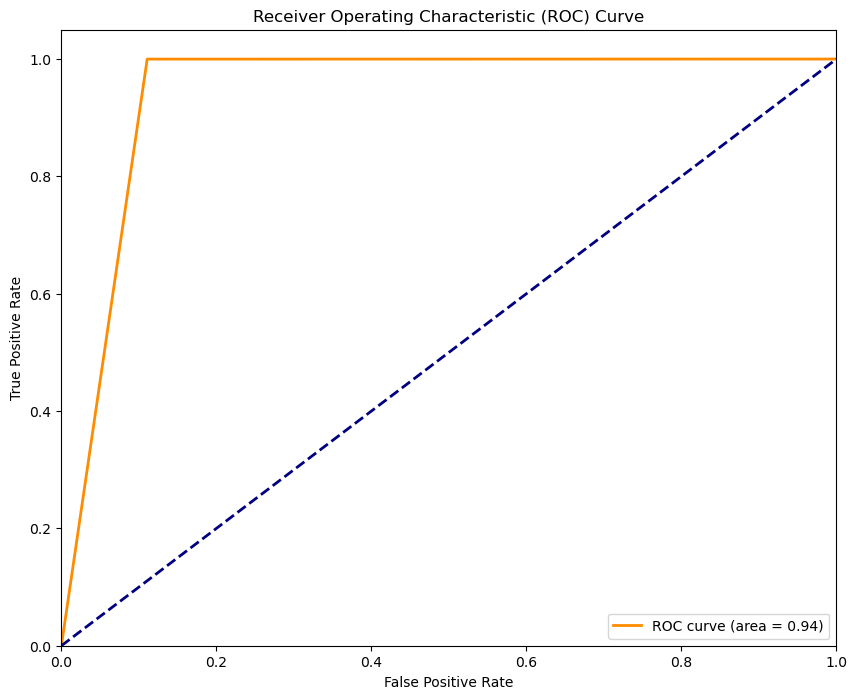

In [105]:
# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

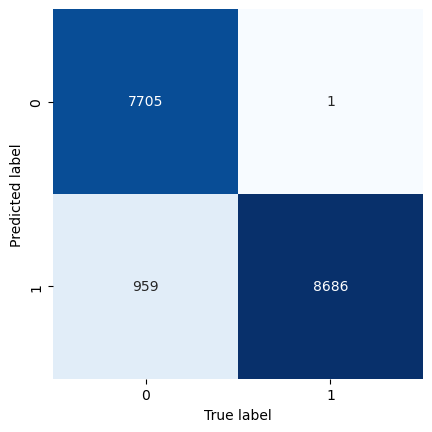

In [155]:
mat2 = confusion_matrix(y_test,y_pred_svc)
# Plot Confusion matrix
sns.heatmap(mat2.T, square=True, annot=True, cbar=False, cmap=plt.cm.Blues, fmt='.0f')
plt.xlabel('True label')
plt.ylabel('Predicted label');
plt.show();

**After comparing the models we can see SVM with VADER is more accurate for the given dataset. As a feature engineering, we added extra sentiment features using Vader to add account to the context of the sentences to determine the sentiment scores.[2] VADER is specifically designed for sentiment analyis, which focuses on the learning sentiment of the text rather than general classification.[5]**

| Metric         | Best Results from step 4  | Results After Using VADER |
|----------------|----------------------------|----------------------------|
| Accuracy       | 94.02%                     | 94.47%                     |
| F1 Score       | 93.89%                     | 94.76%                     |
| Precision (Class 0) | 94%                    | 100%                       |
| Precision (Class 1) | 94%                    | 90%                        |
| Recall (Class 0)    | 94%                    | 89%                        |
| Recall (Class 1)    | 94%                    | 100%                       |
| Support (Class 0)   | 4414 instances         | 8664 instances             |
| Support (Class 1)   | 4262 instances         | 8687 instances             |

### 8. Reviews aspect prediction

**In the given dataset we have individual variables like service, cleanliness, overall, value, location, sleep quality, room etc. In order to find the rating of different aspects of a hotel, we can make a domain-specific sentiment analyzer. We train a separate model with 5 labels 0 to 5 for each aspect required. Then we pass the review text into all the models to get the rating. We can also use pre-trained models like RoBERTa and Bert to classify the keywords in the sentence.[1] Besides, we can use bidirectional LSTM to incorporate the sentiment.  We train separate models using labeled dataset, showing that we can utilize the review text as an input and corresponding aspect rating as target output. Then, we can fine-tune the models to capture domain-specific information. Once the model is trained we can integrate them into a pipeline and pass the text through all aspect-specific models to obtain a corresponding rating.**

### 9. References

[1] Y. Wahba, N. Madhavji, and J. Steinbacher, "Attention Is not Always What You Need: Towards Efficient Classification of Domain-Specific Text: Case-Study: IT Support Tickets," in Intelligent Computing, Springer Nature Switzerland, 2023, pp. 1159-1166. DOI: 10.1007/978-3-031-37963-5_80.

[2] M. Mishra, M. Kang, and J. Woo, "Rating Prediction using Deep Learning and Spark," in Proceedings of the 11th International Conference on Internet (ICONI), KSII, 2019.

[3] Analytics Vidhya, "Predicting Hotel Reviews Ratings with TensorFlow," Medium, [https://medium.com/analytics-vidhya/predicting-the-ratings-of-reviews-of-a-hotel-using-machine-learning-bd756e6a9b9b]

[4] Anis, Sarah & Ismail, Sally & Aref, Mostafa. (2020). Sentiment Analysis of Hotel Reviews Using Machine Learning Techniques. 10.1007/978-3-030-58669-0_21. 

[5] Swarnkar, N. (2020, May 21). "VADER Sentiment Analysis: A Complete Guide, Algo Trading and More." Sentiment Trading [https://blog.quantinsti.com/vader-sentiment/]